In [1]:
import pickle
import pandas as pd   
import numpy as np

import datetime
from sklearn.cluster import KMeans
from sklearn import cluster, metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.manifold import TSNE

import re, string 
from collections import defaultdict
import spacy
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
disaster_specific = ['hurricaneharvey', 'harvey', 'houston', 'texas','hurricanharvey']
# custom_stopwords = custom_words + disaster_specific
custom_words = list(set(
    list(ENGLISH_STOP_WORDS) + list(stopwords.words('english')) +
    ['en', 'amp', 'instagram', 'hurricaneharvey', 'harvey', 'houston', 'texas', 'com', 'county', 'org',
     'www', 'https', 'http', 'rt']))
def process_data_by_tweet(file):
    df = pd.read_file(file)
    # convert to lowercase
    self._remove_extraneous(df, custom_stopwords)
    df['cleaned_tweets'] = self._clean_tweets(df['text'])
    df['lemmatized_tweets'] = self._lemmatize_tweets_spacy(df['cleaned_tweets'])
    return df


In [12]:
# bring in csv and convert each tweet to an item in a list
df = pd.read_csv('../workflow/data/hurricaneharvey/processed_datasets/hurricaneharvey_10000.csv')
tweets = [row.split() for row in df['lemmatized_tweets']]

In [13]:
# create word2vec model finding vectors for each word in the quorum
w2v_model = Word2Vec(sentences=tweets,
                     min_count=1,
                 window=5,
                 size=100,
                 workers=4)

# w2v_model.build_vocab(sentences)
w2v_model.train(tweets, total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)
w2v_model.init_sims(replace=True)


/Users/danielgurzi/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  if __name__ == '__main__':


In [14]:
# calculate the average vector of all words in the tweet and create tweet list with vector scores
vect_score = []

for tweet in tweets:
    tweet_vect = []
    for word in tweet:
        # append the word vector from the model into the tweet_vect list. We will Sum these next. 
        tweet_vect.append(w2v_model.wv[word])
    vect_score.append(sum(tweet_vect)/len(tweet_vect))

df['vect_avgs'] = vect_score
df.head()

,Unnamed: 0,username,to,text,retweets,favorites,replies,id,permalink,author_id,date,formatted_date,hashtags,mentions,geo,urls,cleaned_tweets,lemmatized_tweets,vect_avgs
0,0,ChrisTheYank,NaN,handing church folk supplies need hurricanharv...,0,0,0,914260113971646464,https://twitter.com/ChrisTheYank/status/914260...,342548477,2017-09-30 22:46:11+00:00,Sat Sep 30 22:46:11 +0000 2017,#HurricanHarvey,NaN,NaN,https://www.instagram.com/p/BZrrOONjmQj/,handing church folk supplies need hurricanharv...,hand church folk supply need hurricanharvey p ...,"[-0.028742202, -0.13491492, -0.09629081, -0.02..."
1,1,projectcostello,NaN,brewery supports hurricanharvey relief efforts...,1,2,0,914152662379180033,https://twitter.com/projectcostello/status/914...,1915260643,2017-09-30 15:39:13+00:00,Sat Sep 30 15:39:13 +0000 2017,#HurricanHarvey #HoustonStrong,NaN,NaN,NaN,brewery supports hurricanharvey relief efforts...,brewery support hurricanharvey relief effort h...,"[-0.042152025, -0.1748982, -0.13490002, -0.051..."
2,2,myfriend_bella,NaN,cat friends effected hurricanharvey need help ...,18,44,0,913975189163167745,https://twitter.com/myfriend_bella/status/9139...,3341234925,2017-09-30 03:54:00+00:00,Sat Sep 30 03:54:00 +0000 2017,#cat #HurricanHarvey,NaN,NaN,https://www.gofundme.com/bellasbigadventure,cat friends effected hurricanharvey need help ...,cat friend effect hurricanharvey need help don...,"[-0.0433077, -0.15794578, -0.119382136, -0.044..."
3,3,jaygirl1980,NaN,mtpdaily trump gets lot credit hurricanharvey ...,1,1,2,913883732070846465,https://twitter.com/jaygirl1980/status/9138837...,34695570,2017-09-29 21:50:35+00:00,Fri Sep 29 21:50:35 +0000 2017,#MTPDaily #HurricanHarvey,NaN,NaN,NaN,mtpdaily trump gets lot credit hurricanharvey ...,mtpdaily trump get lot credit hurricanharvey s...,"[-0.020565763, -0.19569878, -0.1405261, -0.035..."
4,4,LSHHann,NaN,day hurricanharvey response w redcross moved s...,0,1,0,913832053791182848,https://twitter.com/LSHHann/status/91383205379...,1586818135,2017-09-29 18:25:14+00:00,Fri Sep 29 18:25:14 +0000 2017,#hurricanharvey,@RedCross,NaN,NaN,day hurricanharvey response w redcross moved s...,day hurricanharvey response w redcross move st...,"[-0.045798972, -0.1759798, -0.14350414, -0.047..."


In [15]:
print('TWEETS')
print(f'Word Count: {sum([len(tweet) for tweet in tweets])}')
print(f'Shortest Tweet: {min([len(tweet) for tweet in tweets])}')

print('\nMODEL')
print(f'Type: {type(w2v_model.wv.vocab)}')
print(f'Length: {len(list(w2v_model.wv.vocab))}')
print('\nVECT_SCORE')
print(f'Type: {type(vect_score)}')
print(f'Length: {len(list(vect_score))}')

TWEETS
Word Count: 83360
Shortest Tweet: 1

MODEL
Type: <class 'dict'>
Length: 14889

VECT_SCORE
Type: <class 'list'>
Length: 10000


In [29]:
# Word2Vec into Kmeans from https://ai.intelligentonlinetools.com/ml/k-means-clustering-example-word2vec/

X = df['vect_avgs']

from nltk.cluster import KMeansClusterer
import nltk
kclusterer = KMeansClusterer(num_means=20, distance=nltk.cluster.util.cosine_distance, 
                             repeats=25,avoid_empty_clusters=True)
df['clusters'] = kclusterer.cluster(X, assign_clusters=True)


/Users/danielgurzi/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
w2v_model.wv.vocab.keys()

dict_keys(['hand', 'church', 'folk', 'supply', 'need', 'hurricanharvey', 'p', 'bzrroonjmqj', 'brewery', 'support', 'relief', 'effort', 'houstonstrong', 'host', 'local', 'artist', 'musician', 'vendor', 'food', 'truck', 'cat', 'friend', 'effect', 'help', 'donation', 'sept', 'bba', 'adl', 'tx', 'gofundme', 'bellasbigadventure', 'mtpdaily', 'trump', 'get', 'lot', 'credit', 'see', 'ton', 'town', 'people', 'boat', 'save', 'live', 'govt', 'day', 'response', 'w', 'redcross', 'move', 'stairwell', 'conference', 'call', 'weekend', 'thecurrentflow', 'fundrais', 'student', 'affect', 'come', 'htx', 'bit', 'ly', 'xrnqzw', 'iconearlyphaseservices', 'diabetes', 'donate', 'kissonline', 'raise', 'school', 'fine', 'art', 'pgm', 'destroy', 'khs', 'musicforhouston', 'xldf', 'love', 'bethatkindofneighbor', 'kidshelpingkid', 'bethatkindofkid', 'super', 'cool', 'brother', 'take', 'aerial', 'view', 'flood', 'area', 'skyviperdrone', 'joelosteen', 'stay', 'strong', 'know', 'try', 'hard', 'reputation', 'break', 'h

In [30]:
# Print words from model
words = list(w2v_model.wv.vocab)
for i, word in enumerate(words):  
    print (word + ":" + str(assigned_clusters[i]))

hand:12
church:17
folk:12
supply:17
need:8
hurricanharvey:12
p:12
bzrroonjmqj:2
brewery:11
support:13
relief:13
effort:13
houstonstrong:8
host:11
local:17
artist:16
musician:17
vendor:16
food:17
truck:11
cat:12
friend:14
effect:14
help:8
donation:13
sept:13
bba:13
adl:13
tx:12
gofundme:17
bellasbigadventure:17
mtpdaily:17
trump:9
get:12
lot:12
credit:11
see:11
ton:11
town:11
people:8
boat:11
save:12
live:11
govt:11
day:11
response:11
w:12
redcross:13
move:11
stairwell:13
conference:16
call:11
weekend:17
thecurrentflow:17
fundrais:17
student:12
affect:14
come:7
htx:17
bit:19
ly:19
xrnqzw:18
iconearlyphaseservices:18
diabetes:19
donate:13
kissonline:11
raise:17
school:12
fine:7
art:11
pgm:16
destroy:11
khs:19
musicforhouston:19
xldf:19
love:14
bethatkindofneighbor:12
kidshelpingkid:12
bethatkindofkid:17
super:17
cool:11
brother:12
take:11
aerial:16
view:11
flood:7
area:8
skyviperdrone:17
joelosteen:11
stay:14
strong:14
know:12
try:11
hard:12
reputation:12
break:12
haarp:17
weatherweapon:

In [78]:
w2v_model[w2v_model.wv.vocab]

/Users/danielgurzi/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([[-0.04061134, -0.1745427 , -0.14550349, ..., -0.04209764,
        -0.15988214,  0.05129121],
       [-0.03402194, -0.19037004, -0.14439745, ..., -0.03860349,
        -0.14111054,  0.04336996],
       [-0.0296676 , -0.19582888, -0.12938654, ..., -0.03693509,
        -0.13579088,  0.03814953],
       ...,
       [ 0.0260233 , -0.15393367, -0.18625377, ..., -0.08624213,
        -0.17028545,  0.02637322],
       [-0.02072194, -0.18831472, -0.1552501 , ...,  0.02740712,
        -0.126347  ,  0.06808948],
       [-0.02582035, -0.16528726, -0.14901328, ..., -0.01735463,
        -0.0788068 ,  0.03363074]], dtype=float32)

In [85]:
[a for a in df['vect_avgs']]

[array([-0.0287422 , -0.13491492, -0.09629081, -0.02702033,  0.15956879,
        -0.1149574 ,  0.01003008, -0.08118174, -0.1656906 , -0.00179999,
         0.174672  ,  0.0410016 ,  0.18187825,  0.1699863 ,  0.1815134 ,
        -0.05007187,  0.10372233,  0.0859012 , -0.01963461,  0.11095871,
         0.12411623,  0.08168639,  0.04379909,  0.04028205, -0.02486322,
         0.05418526,  0.00550359,  0.06084037,  0.02276887,  0.07208187,
        -0.0449029 , -0.02973916,  0.05437331, -0.06912131,  0.10651724,
        -0.0593154 , -0.05358214,  0.00149803,  0.06005091, -0.03985481,
        -0.03877895, -0.02500594,  0.01229329, -0.03875607, -0.11587375,
        -0.09203941, -0.00293099,  0.10832056, -0.1108192 ,  0.03115297,
        -0.03306678,  0.00703498,  0.03713302, -0.05615006,  0.14445399,
         0.02582376,  0.00779747, -0.02144943,  0.07189728,  0.02995197,
        -0.01988474,  0.04633572,  0.05471897,  0.07469038, -0.09226243,
        -0.14423993, -0.03663241,  0.07718133,  0.0

In [54]:
w2v_model[w2v_model.wv.vocab]

{'hand': <gensim.models.keyedvectors.Vocab at 0x119b1a490>,
 'church': <gensim.models.keyedvectors.Vocab at 0x119b1a9d0>,
 'folk': <gensim.models.keyedvectors.Vocab at 0x119b1a510>,
 'supply': <gensim.models.keyedvectors.Vocab at 0x119b1a610>,
 'need': <gensim.models.keyedvectors.Vocab at 0x119b062d0>,
 'hurricanharvey': <gensim.models.keyedvectors.Vocab at 0x1a217fdf50>,
 'p': <gensim.models.keyedvectors.Vocab at 0x1a217fdf90>,
 'bzrroonjmqj': <gensim.models.keyedvectors.Vocab at 0x1a217fdfd0>,
 'brewery': <gensim.models.keyedvectors.Vocab at 0x119b1a5d0>,
 'support': <gensim.models.keyedvectors.Vocab at 0x1a217fdf10>,
 'relief': <gensim.models.keyedvectors.Vocab at 0x1a23869050>,
 'effort': <gensim.models.keyedvectors.Vocab at 0x1a23869090>,
 'houstonstrong': <gensim.models.keyedvectors.Vocab at 0x1a238690d0>,
 'host': <gensim.models.keyedvectors.Vocab at 0x1a23869110>,
 'local': <gensim.models.keyedvectors.Vocab at 0x1a23869150>,
 'artist': <gensim.models.keyedvectors.Vocab at 0x1a2

In [86]:
X = [a for a in df['vect_avgs']]

kmeans = cluster.KMeans(n_clusters=20)
kmeans.fit(X)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
 
print ("Cluster id labels for inputted data")
print (labels)
print ("Centroids data")
print (centroids)
 
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
 
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
 
print ("Silhouette_score: ")
print (silhouette_score)

Cluster id labels for inputted data
[ 1 15  7 ... 17 16 10]
Centroids data
[[-0.03215292 -0.18922057 -0.13084586 ... -0.03898778 -0.1371849
   0.04033178]
 [-0.02753295 -0.14460742 -0.0949738  ... -0.01626674 -0.108335
   0.02792223]
 [-0.01427958 -0.20536923 -0.11150112 ...  0.01335423 -0.10759431
   0.02946464]
 ...
 [-0.03203669 -0.19773292 -0.14375397 ... -0.03341075 -0.13916304
   0.04496566]
 [-0.03259996 -0.19883786 -0.15292362 ... -0.03676767 -0.14120779
   0.05011046]
 [-0.05257095 -0.18850153 -0.13476096 ... -0.04639801 -0.14106732
   0.04265403]]
Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):
-60.54093653029294
Silhouette_score: 
0.1957571


In [90]:
df['cluster'] = labels

In [127]:
df.groupby('cluster').count()['text']

cluster
0      842
1       83
2      147
3      362
4      819
5      218
6     1160
7      198
8      305
9       38
10     624
11     231
12      47
13     117
14     130
15     561
16     544
17    1542
18    1800
19     232
Name: text, dtype: int64

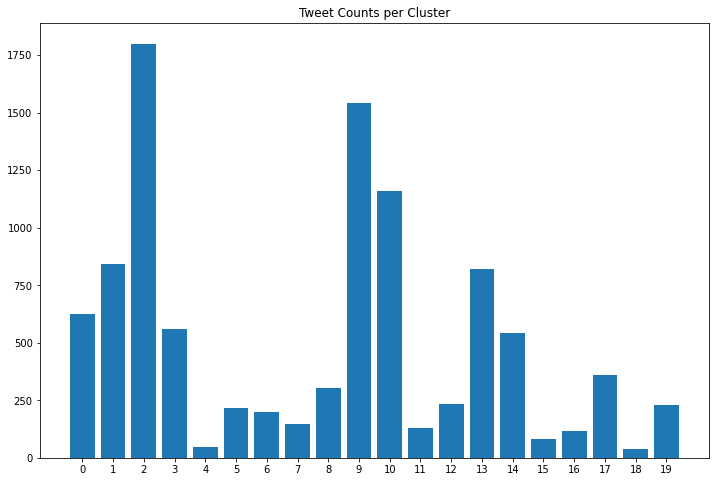

In [136]:
plt.figure(figsize=(12,8))
plt.title("Tweet Counts per Cluster")
plt.xticks(range(0,20))
plt.bar(df['cluster'].unique(),df.groupby('cluster').count()['text']);

In [153]:
pd.options.display.max_colwidth = 240

df[df['text'].str.contains("drown")]


,Unnamed: 0,username,to,text,retweets,favorites,replies,id,permalink,author_id,date,formatted_date,hashtags,mentions,geo,urls,cleaned_tweets,lemmatized_tweets,vect_avgs,cluster
2133,2133,MicheleCitizen,TheaGood,hurricanharvey family membrs drowned van hs prayers family hur survivors home kiss yr kids nite,0,0,0,903005307089149952,https://twitter.com/MicheleCitizen/status/903005307089149952,826256039096045569,2017-08-30 21:23:36+00:00,Wed Aug 30 21:23:36 +0000 2017,#HurricanHarvey,NaN,NaN,https://twitter.com/TheaGood/status/902472497584582657,hurricanharvey family membrs drowned van hs prayers family hur survivors home kiss yr kids nite,hurricanharvey family membrs drown van hs prayers hur survivors home kiss yr kid nite,"[-0.028532166, -0.19162706, -0.1472425, -0.04235362, 0.197319, -0.15413666, 0.03176781, -0.104048796, -0.17905322, -0.0016360438, 0.20405461, 0.027537921, 0.21710266, 0.18954296, 0.2181193, -0.05125468, 0.1288276, 0.09212096, -0.0379915...",6
2392,2392,Joy105com,NaN,baby clinging mother drowned body joy index php baby clinging mothers drowned body hurricanharvey,0,0,0,902877514804060160,https://twitter.com/Joy105com/status/902877514804060160,405051209,2017-08-30 12:55:48+00:00,Wed Aug 30 12:55:48 +0000 2017,#Texas #Houston #HurricanHarvey,NaN,NaN,http://joy105.com/index.php/2017/08/30/baby-found-clinging-to-her-mothers-drowned-body-in-texas/,baby clinging mother drowned body joy index php baby clinging mothers drowned body hurricanharvey,baby cling mother drown body joy index php hurricanharvey,"[-0.027036183, -0.2065727, -0.15208411, -0.036043033, 0.18456548, -0.14854153, 0.027951436, -0.07816584, -0.19084308, -0.0014516187, 0.1876268, 0.017096423, 0.20191218, 0.19508, 0.16672279, -0.037123278, 0.13503583, 0.06892644, -0.03319...",4
2440,2440,deakhandotpng,NaN,hope drowns hurricanharvey,0,4,0,902800325156888576,https://twitter.com/deakhandotpng/status/902800325156888576,730556864744677376,2017-08-30 07:49:05+00:00,Wed Aug 30 07:49:05 +0000 2017,#HurricanHarvey,NaN,NaN,NaN,hope drowns hurricanharvey,hope drowns hurricanharvey,"[-0.03214953, -0.17137499, -0.12301022, -0.041183457, 0.2010067, -0.15672967, 0.025780283, -0.13582416, -0.15737559, 0.005879191, 0.22803497, 0.02228207, 0.23731868, 0.17568512, 0.26314536, -0.06820021, 0.12243525, 0.11848697, -0.025995...",10
2647,2647,emilyneppxx,NaN,right going terrible time saw right eyes drown self hurricanharvey,1,0,0,902674561061281793,https://twitter.com/emilyneppxx/status/902674561061281793,1367265828,2017-08-29 23:29:20+00:00,Tue Aug 29 23:29:20 +0000 2017,#HurricanHarvey,NaN,NaN,NaN,right going terrible time saw right eyes drown self hurricanharvey,right go terrible time see eye drown self hurricanharvey,"[-0.02881774, -0.20206028, -0.14501132, -0.033934124, 0.18945347, -0.15200782, 0.032143228, -0.098029725, -0.18367934, -0.0076638577, 0.1983725, 0.02254821, 0.21199125, 0.19636172, 0.19592103, -0.048656683, 0.13432515, 0.09223721, -0.02...",17
2941,2941,BrianMarvel,NaN,houstonpolice ofcr drowned hurricanharvey floodwaters mourning loss ow ly rcz elknk hpoutx houstonstrong lesm,2,4,1,902580401050329088,https://twitter.com/BrianMarvel/status/902580401050329088,50344100,2017-08-29 17:15:11+00:00,Tue Aug 29 17:15:11 +0000 2017,#HurricanHarvey #HoustonStrong,@houstonpolice @HPOUTX,NaN,http://ow.ly/4RCz30eLknk,houstonpolice ofcr drowned hurricanharvey floodwaters mourning loss ow ly rcz elknk hpoutx houstonstrong lesm,houstonpolice ofcr drown hurricanharvey floodwater mourning loss ow ly rcz elknk hpoutx houstonstrong lesm,"[-0.04333553, -0.17009807, -0.15630005, -0.060999088, 0.1744765, -0.15734367, 0.016792918, -0.07071393, -0.18883903, 0.025634345, 0.20329829, 0.040617596, 0.22159253, 0.20653783, 0.18742599, -0.028480632, 0.120024435, 0.051876534, -0.06...",5
2944,2944,SDPOA,NaN,houstonpolice officer drowns hurricanharvey floodwaters prayers difficult time ow ly rcz elknk hpoutx,15,14,4,902579343246979072,https://twitter.com/SDPOA/status/902579343246979072,41231

### Word 2 Vec Probing

In [34]:
w2v_model.wv['word']

array([ 1.11864917e-02,  1.69459820e-01,  2.36830413e-02,  1.67115524e-01,
       -6.59481138e-02,  1.40680581e-01, -8.54235068e-02,  1.40905669e-02,
        4.71831001e-02,  7.94195756e-02,  1.24174513e-01,  1.18081175e-01,
       -9.60753113e-02,  6.73331395e-02,  6.52271992e-05, -1.30175874e-01,
        4.22906131e-02,  1.71330664e-02, -3.38523611e-02,  1.41784340e-01,
        4.02951874e-02, -3.15934718e-02,  1.76126197e-01,  1.45705754e-03,
       -1.46193355e-01, -3.97961885e-02,  9.58292559e-02, -2.70748343e-02,
        1.85815021e-01,  8.78805816e-02, -7.04782605e-02, -4.35773991e-02,
        1.89138763e-03, -5.60942888e-02,  7.38484710e-02, -5.30408733e-02,
       -3.77029330e-02,  5.05214781e-02,  1.69580802e-01,  1.65710345e-01,
        1.32989049e-01,  1.81724638e-01,  4.28448506e-02,  1.25911981e-02,
       -7.56782219e-02, -1.84949577e-01, -3.26659642e-02, -2.98958626e-02,
       -4.19060327e-02,  7.25733042e-02, -8.84897187e-02, -7.52589712e-03,
        6.35334030e-02,  

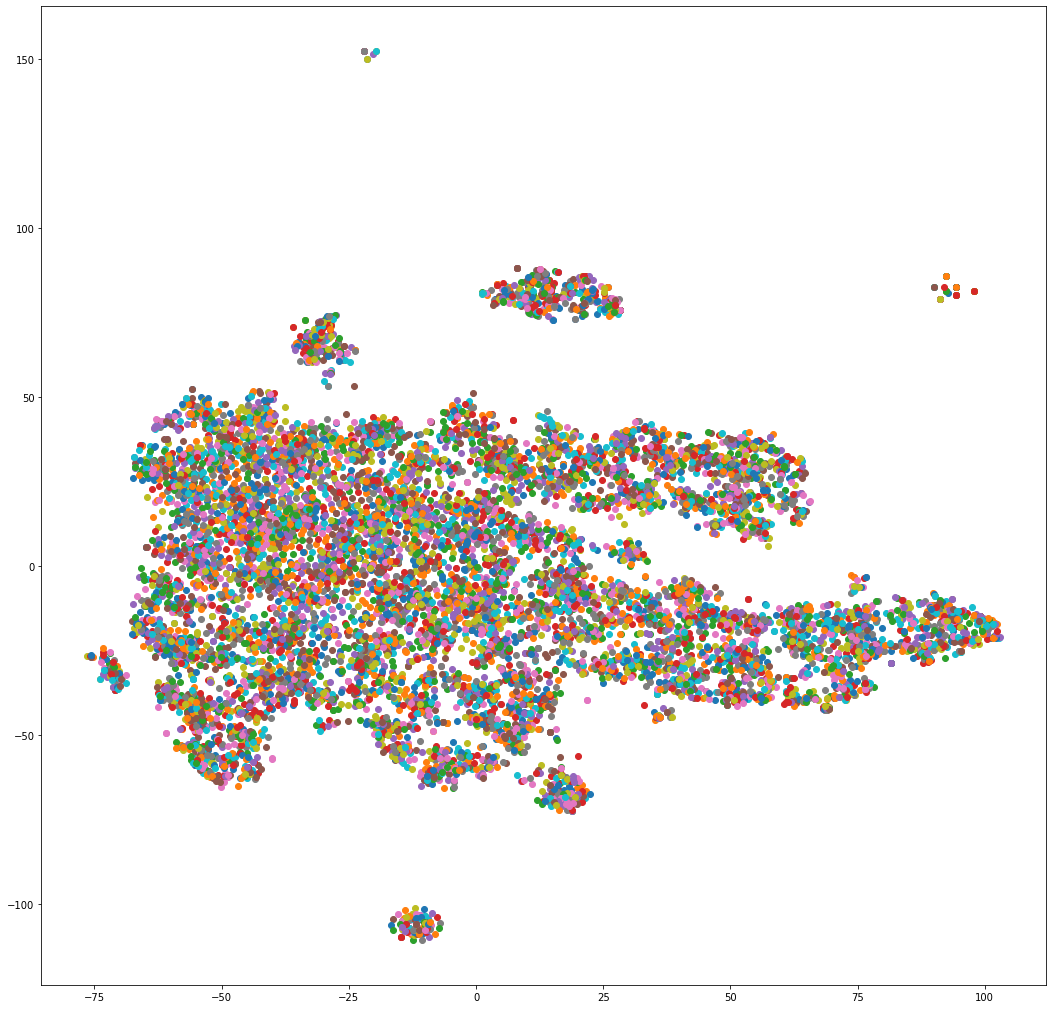

In [28]:
# from https://towardsdatascience.com/understanding-word2vec-embedding-in-practice-3e9b8985953

def tsne_plot(model):
    "Create TSNE model and plot it"
    labels = []
    tokens = []

    for ind, tweet in enumerate(df['text']):
        tokens.append(df['vect_avgs'][ind])
        labels.append(tweet)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=42)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(18, 18)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
#         plt.annotate(labels[i],
#                      xy=(x[i], y[i]),
#                      xytext=(5, 2),
#                      textcoords='offset points',
#                      ha='right',
#                      va='bottom')
    plt.show()
   
tsne_plot(w2v_model)

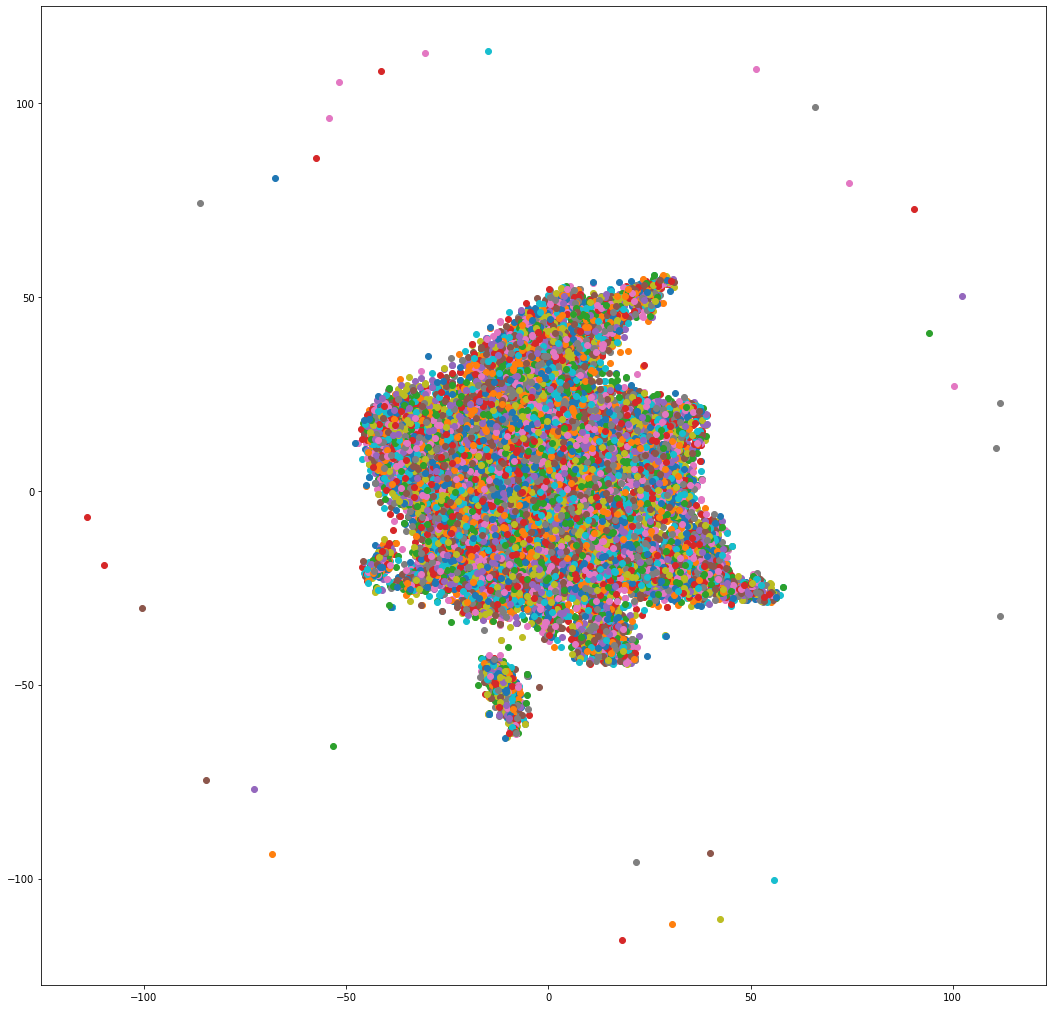

In [18]:
# from https://towardsdatascience.com/understanding-word2vec-embedding-in-practice-3e9b8985953

def tsne_plot(model):
    "Create TSNE model and plot it"
    labels = []
    tokens = []

    for word in w2v_model.wv.vocab.keys():
        tokens.append(w2v_model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=42)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(18, 18)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
#         plt.annotate(labels[i],
#                      xy=(x[i], y[i]),
#                      xytext=(5, 2),
#                      textcoords='offset points',
#                      ha='right',
#                      va='bottom')
    plt.show()
   
tsne_plot(w2v_model)

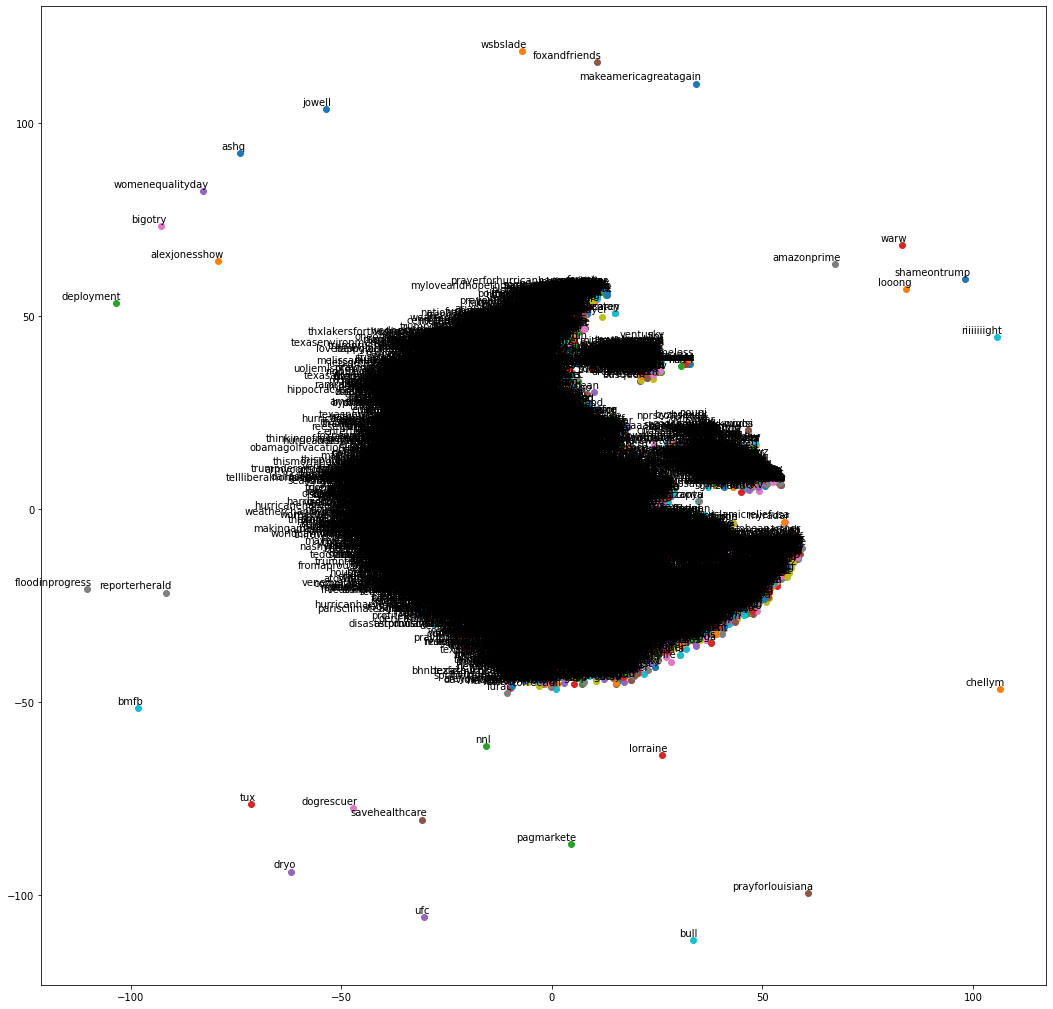

In [35]:
# from https://towardsdatascience.com/understanding-word2vec-embedding-in-practice-3e9b8985953

def tsne_plot(model):
    "Create TSNE model and plot it"
    labels = []
    tokens = []

    for word in w2v_model.wv.vocab.keys():
        tokens.append(w2v_model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=42)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(18, 18)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
   
tsne_plot(w2v_model)